[[31, -10], [7, -1], [22.0, -34.0], [-2.0000000000000036, -25.0]]


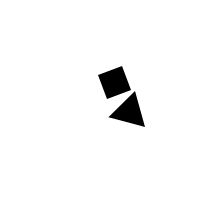

In [23]:
"""
# Test shape creation

"""
import sys
import drawsvg as dw

sys.path.append('./packages')
from synth.synthesise import gTri, gSquare

d = dw.Drawing(width = 200, height = 200, origin = (-100,-100), id_prefix='d')

tri = gTri()["p"]
p = dw.Path()
p.M(*tri[0]).L(*tri[1]).L(*tri[2])
d.append(p)

sq = gSquare()["p"]
print(sq)
p = dw.Path()
p.M(*sq[0]).L(*sq[1]).L(*sq[3]).L(*sq[2])
d.append(p)
d

In [24]:
"""
# Generate Synthetic dataset.
- 1 graph for each shape.

"""
import torch
from torch_geometric.data import Data
from random import choice
from synth.synthesise import gTri, gSquare, gPoint, gLine

g_funcs = [gLine, gTri, gSquare]
nums = 50
tensors = []
for i in range(0, nums):
    fx = choice(g_funcs)
    d = fx()
    edge_idx = torch.tensor(d["e"], dtype = torch.long)
    pos = torch.tensor(d["p"], dtype = torch.float)
    shape = torch.tensor(d["s"], dtype = torch.int)
    data = Data(edge_index = edge_idx.t().contiguous(), x=pos, pos = pos, shape = shape)
    data.validate(raise_on_error = True)
    tensors.append(data)
    pass
    
print("Tensors created")
choice(tensors).is_undirected()
tensors[0].num_node_features
tensors[0].pos
tensors[0].edge_index

Tensors created


tensor([[0, 1, 2, 3],
        [1, 2, 3, 0]])

In [26]:
"""
# Create Graph Neural Network (WIP)

"""
import torch.nn.functional as F
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.pool import global_mean_pool

node_gmp = global_mean_pool(tensors[0].x, None)
# TODO: Set up Message Passing to encode connectivity

# Copied from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html
# TODO: Modify to suit current GNN requirement.
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add")
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()
        pass

    def forward(self, x, edge_index):
        # x [N, in_channels]; represents node feature matrix
        # 1. Add self loops to adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
        
        # 2. Linearly transform node feature matrix
        x = self.lin(x)

        # 3. Compute normalisation of node features
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias
        pass

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    pass